In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

np.random.seed(0)

# Settings
P0 = 3.8
Pdec = 1000
tmax = 200
amp = [3.0, 1.0, 0.33]
der = [1.0, 4.0, 0.5]
nt = [40000, 100, 50]


In [21]:
def func_deriv(t, p0, amp, der):
    return amp * np.sin(2 * np.pi * t / p0) + der * np.cos(2 * np.pi * t / p0) 

(40000,)


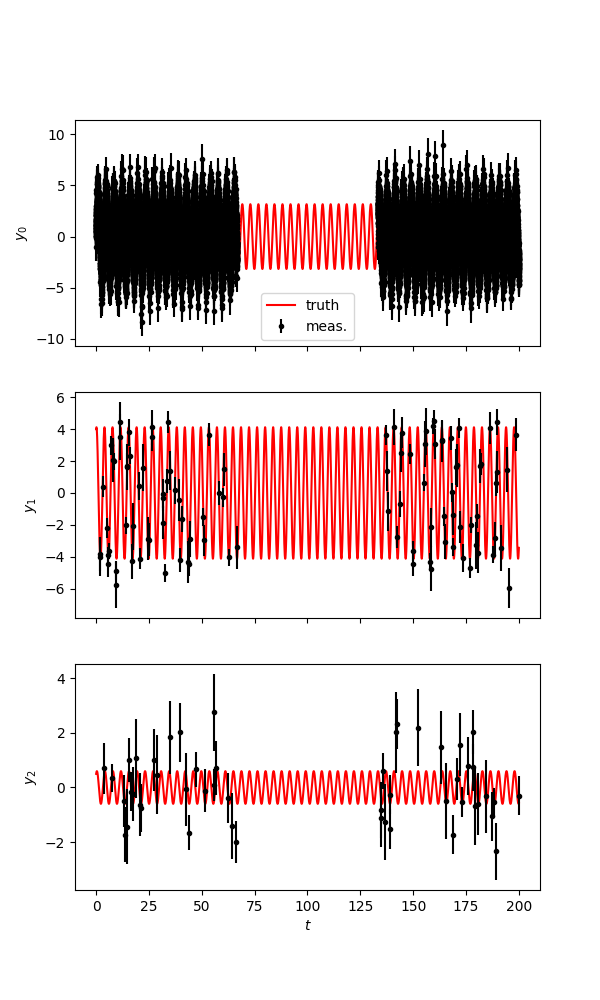

In [22]:
# True signal
tsmooth = np.linspace(0, tmax, 40000)
Ysignal = [
  func_deriv(tsmooth, P0, ak, dk)
  for ak, dk in zip(amp, der)
]


# Generate observations calendars
T = [
  np.sort(
  np.concatenate((np.random.uniform(0, tmax / 3,
  ntk // 2), np.random.uniform(2 * tmax / 3, tmax, (ntk + 1) // 2))))
  for ntk in nt
]

# Generate measurements with white noise
Yerr = [np.random.uniform(0.5, 1.5, ntk) for ntk in nt]
Y = [ func_deriv(T[k], P0, amp[k], der[k]) +
  np.random.normal(0, Yerr[k]) for k in range(3)
]

# Plot
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()

print(np.shape(T[0]))

In [23]:
## test 

test = []
yerr = []
for k in range(0,3):
    test.append(func_deriv(T[k], P0, amp[k], der[k]))
for k in range(0,3):
    yerr.append(test[k]**2)




In [25]:
from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Merge all 3 time series
t_full, y_full, yerr_full, series_index = cov.merge_series(T, Y, Yerr)


In [26]:
# Initialize the S+LEAF model
import time
time0 = time.time()
D = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 2., 1000.0, 0.35), series_index,
  np.ones(3), np.zeros(3)))
time1 = time.time()
print(time1-time0)

print(series_index[0])

0.11904096603393555
[    0     1     2 ... 40147 40148 40149]


In [29]:
time0 = time.time()

kwargs = {
    'err': term.Error(yerr_full),
    'GP': term.MultiSeriesKernel(term.ESPKernel(1.0, 2., 1000.0, 0.35), series_index,
  np.ones(3), np.zeros(3)),
    'jitter_inst00': term.InstrumentJitter(series_index[0], 0.01),
    'jitter_inst01': term.InstrumentJitter(series_index[1], 0.01),
    'jitter_inst02': term.InstrumentJitter(series_index[2], 0.01),
}

D1 = cov.Cov(t_full, **kwargs)
time1 = time.time()
print(time1-time0)

print(D1.param)

### PAY ATTENTION HERE
param = D.param[1:]



0.09614682197570801
['GP.sig', 'GP.P', 'GP.rho', 'GP.eta', 'GP.alpha_0', 'GP.alpha_1', 'GP.alpha_2', 'GP.beta_0', 'GP.beta_1', 'GP.beta_2', 'jitter_inst00.sig', 'jitter_inst01.sig', 'jitter_inst02.sig']


In [30]:
# Fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.param
# List of parameters to fit
param = D.param[1:]
# The amplitude of the kernel is fixed at 1 (not fitted),
# since it would be degenerated with the amplitudes alpha, \beta.


bounds = np.zeros([len(param),2])
bounds[4:,0] = -10
bounds[:,1] = 220
bounds[10:,0] = 0.0
bounds[10:,1] = 2.0

bounds[0,:] = [1.6, 10.2]
bounds[1,:] = [500, 2000]
bounds[2,:] = [0, 0.50]
bounds[3,:] = [0, 0.50]

y = y_full

# Define the function to minimize
def negloglike(x, y, D):
  D.set_param(x, param)
  nll = -D.loglike(y)
  # gradient
  nll_grad = -D.loglike_grad()[1][1:]
  return (nll, nll_grad)

def pyde_function(x):
  #print(x)
  sel = (x < bounds[:,0]) | (x>bounds[:,1])
  if np.sum(sel) > 0:
    return -np.inf
  D.set_param(x, param)
  ll = D.loglike(y)
  return ll


from pyde.de import DiffEvol
de = DiffEvol(pyde_function, bounds, 50, maximize=True)
res = de.optimize(ngen=510000)




In [31]:
print(bounds)
print(res)
print(param)




[[ 1.60e+00  1.02e+01]
 [ 5.00e+02  2.00e+03]
 [ 0.00e+00  5.00e-01]
 [ 0.00e+00  5.00e-01]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]]
(array([ 7.60007147e+00,  1.99927790e+03,  3.54519272e-03,  1.69704727e-01,
       -1.83020765e+00, -2.46415844e-01,  1.06059353e+00,  8.97139455e-01,
        1.34864401e-01]), 55157.154001213275)
['GP.P', 'GP.rho', 'GP.eta', 'GP.alpha_0', 'GP.alpha_1', 'GP.alpha_2', 'GP.beta_0', 'GP.beta_1', 'GP.beta_2']


In [ ]:


# Fit
#xbest, _, _ = fmin_l_bfgs_b(negloglike, D.get_param(param), args=(y_full, D))

xbest = res[0]
print(xbest)
# Use S+LEAF to predict the missing data

D.set_param(xbest, param)
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  # Predict time series k
  D.kernel['GP'].set_conditional_coef(series_id=k)
  mu, var = D.conditional(y_full, tsmooth, calc_cov='diag')

  # Plot
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.fill_between(tsmooth,
    mu - np.sqrt(var),
    mu + np.sqrt(var),
    color='g',
    alpha=0.5)
  ax.plot(tsmooth, mu, 'g', label='predict.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()
plt.show()

[ 7.60007147e+00  1.99927790e+03  3.54519272e-03  1.69704727e-01
 -1.83020765e+00 -2.46415844e-01  1.06059353e+00  8.97139455e-01
  1.34864401e-01]
